<h1 style='text-align: center'>Full Implementation of a QDA Classifier on a Sign Language Dataset:</h1> <br>
<h3 style='text-align: center'>Almog Rabani &nbsp&nbsp Yakir Hasid</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

<h3>1: Loading the train data and prepare the train data for the classifier</h3>

<h4><u>1a: Loading the train data and split into features and labels</u></h4>

In [2]:
# Load the train data
TrainData = pd.read_pickle("TrainData.pkl")

# split into features and labels
XTrainData = TrainData['X']
YTrainData = TrainData['Y']

# the representation of each possible label
target_names = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

<h4><u>1b: Images for every label in the train data</u></h4>

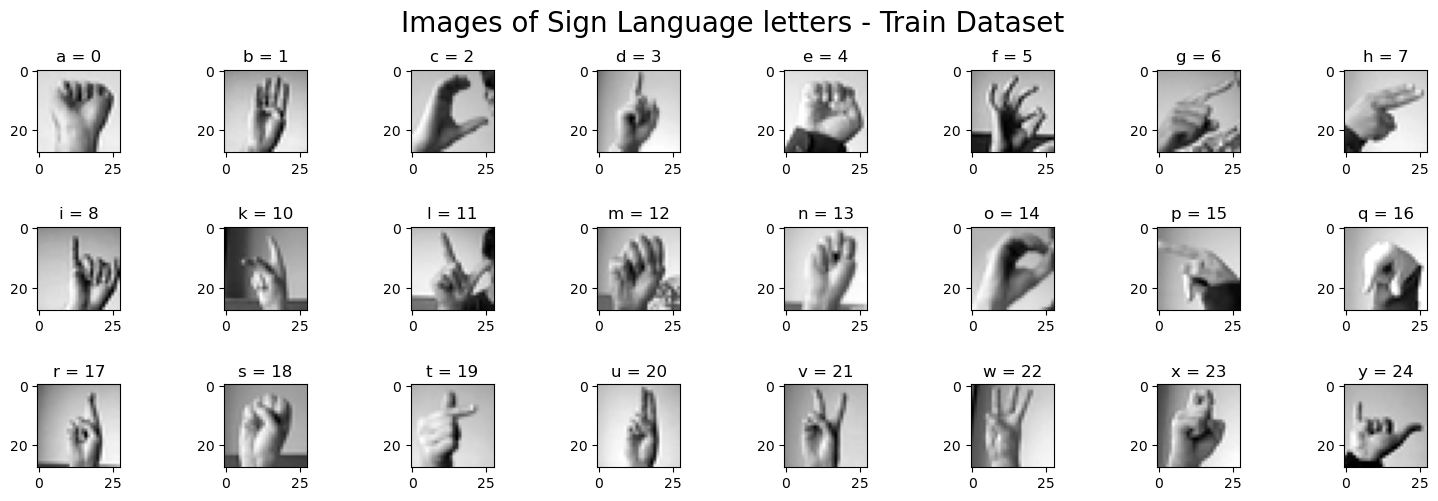

In [3]:
# create the figure and adjust the size
plt.figure(figsize=(18,3));
plt.gcf().suptitle("Images of Sign Language letters - Train Dataset", fontsize=20, y=3.2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=3, 
                    wspace=0.4, 
                    hspace=0.9)

# for each unique letter in the data
for index, val in enumerate(np.unique(YTrainData)):
    # find the positions where the label is a certain letter
    pos = np.argwhere(YTrainData==val)        
               
    plt.subplot(6,8,index+1);      
    
    # take the first occurence of the letter
    plt.imshow(XTrainData[:,:,pos[0]], cmap='gray') 
    
    # add the label to the picture
    plt.title(target_names[val] + " = " + str(val))          
plt.show()

<h4><u>1c: Prepare the train data for the classifier</u></h4>

In [4]:
# using transpose to define the rows as the examples
# using reshape to convert from 3d to 2d matrix
# using astype to convert data type from int to float64
XTrain = XTrainData.transpose(2,0,1).reshape(XTrainData.shape[2],-1).astype('float64')

# categorize the labels into labels in asscending order
# that way our QDA algorithm is independent on missing values in the data
[Labels, YTrain] = np.unique(YTrainData, return_inverse=True)

<h3>2: Mathematical identity for $\hat{y}(x)$</h3>

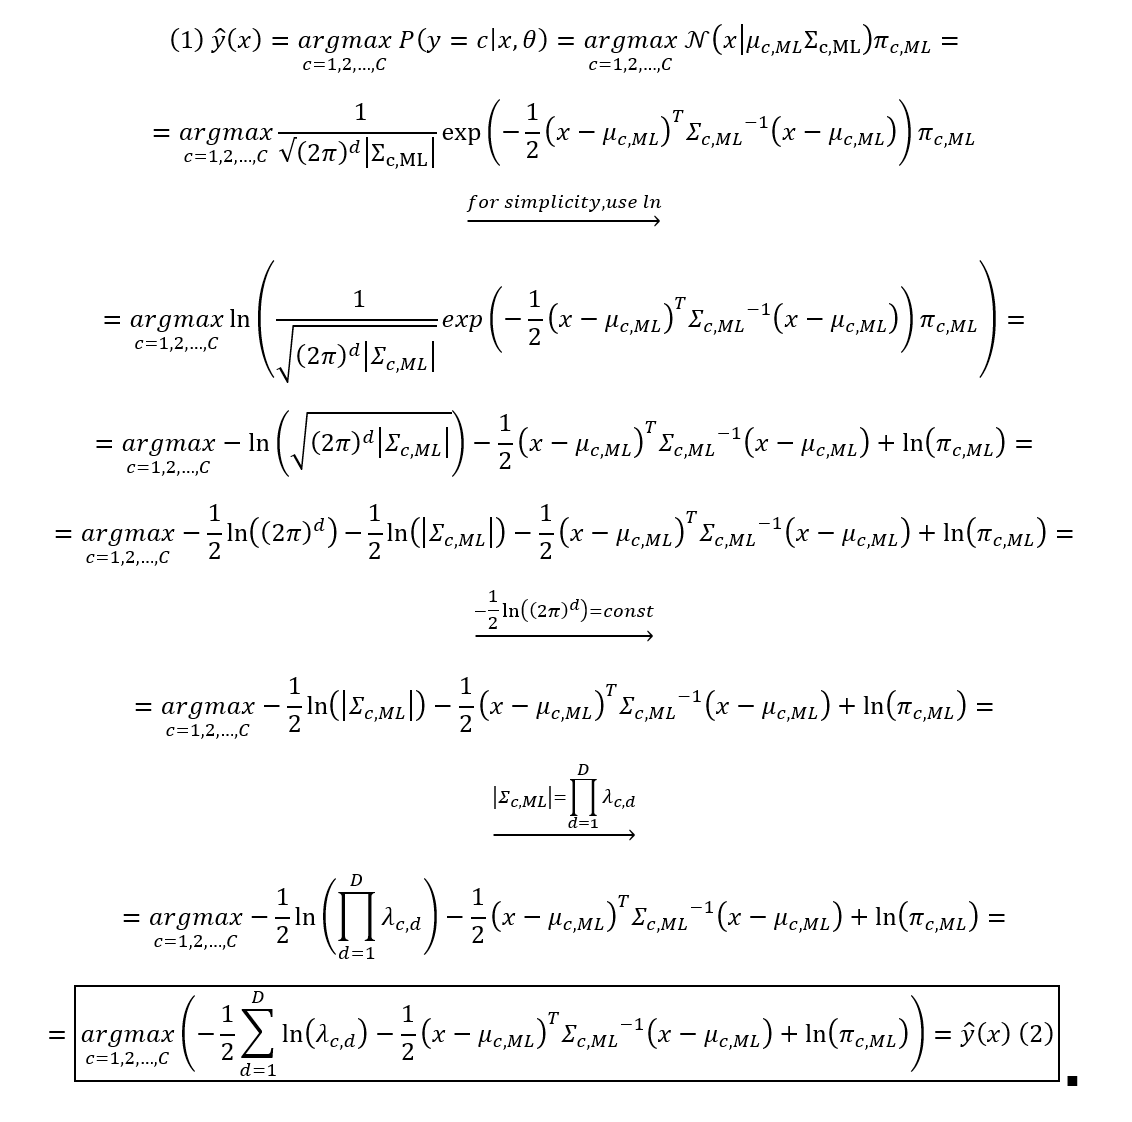

<h3>3: QDA Classifier Implementation for Multi Dimension Data</h3>

<h4><u>3a: Maximum Likelihood Estimation for the Model Parameters</u></h4>

In [5]:
def ml_est(XTrain, YTrain):
    """
    Input - XTrain - The features of the data
            YTrain - The labels of the data
    Output - pi_ml - prior probability for each label
             u_ml - mean for each feature
             cov_ml - features covariance for each label
    Description - Maximum Likelihood Estimation for the Model Parameters
    """
    # init parameters
    pi_ml = []
    u_ml = []
    cov_ml = []
    
    # calculate the model parameters for every label
    for k in np.unique(YTrain):
        # calculate pi_ml 
        YTrain_c = (YTrain == k)
        pi_ml.append(YTrain_c.mean())

        # using the unbiased estimation for cov_ml and u_ml
        # in order to be more accurate and get consistent results        
        
        # calculate u_ml        
        u_ml.append(XTrain[YTrain_c].mean(axis=0))
    
        # calculate cov_ml      
        N_c = YTrain_c.sum()       
        cov = (1/(N_c)) * XTrain[YTrain_c].transpose() @ XTrain[YTrain_c] - np.outer(u_ml[k], u_ml[k])        
        cov_ml.append((N_c/(N_c-1))*cov)        
        
    return [np.array(pi_ml), np.array(u_ml), np.array(cov_ml)]

Calculate Maximum Likelihood Parameters for the QDA model:

In [6]:
# using ml estimator function in order to calculate the model parameters
[pi_ml, u_ml, cov_ml] = ml_est(XTrain, YTrain)

<h4><u>3b: Implementation of the classifier</u></h4>

When calculating the probability of $P(y=c |x,\theta)$, we could have chosen two different implementations. Mathematically both will yield the same result, as shown in Q2. However, due to computer limitations, by using the first implementation, we may encounter values that will lead to incorrect results, due to the multiplication of very low values that could be saved as absolute zero. Therefore, when using the second implementation, which instead of multiplying the eigenvalues, adds them, we prevent the problem of dividing by zero. <br><br>
In our case, when calculating the determinant of the images, because some rows and columns could have a strong linear dependence, because the images have a mostly constant background, we need to use the second implementation.

In [7]:
def classify(X, pi_ml, u_ml, cov_ml):
    """
    Input - X - a matrix of unclassified examples
            pi_ml, u_ml, cov_ml - the model parameters
    Output - Classifications of the given examples
    Description - Classifies the given examples using the model parameters
                  By calculating the probability through the labels and choosing the one that maximzes the probability
    """   
    # init
    P_X_c = np.zeros((X.shape[0], u_ml.shape[0]))
   
    # for each label calculate the probability
    ### calculating labelwise instead of examplewise improves improves speed and efficiency
    for k in range(len(pi_ml)):
      
        # calculate the probability that the examples are of label k
        P_X_c[:,k] = prob(X, pi_ml[k], u_ml[k], cov_ml[k])      
    
    # choose the label that maximizes the probability for each example
    return np.argmax(P_X_c, 1)
        
def prob(X, pi, u, cov): 
    """
    Input - X - a matrix of examples
            The Model Parameters:
            pi - a vector of prior probability of the label
            u - a vector of mean of the label
            cov - a matrix of the covariance of the label            
    Output - The probability the examples X are the checked label
    Description - Uses the second implementation to calculate the probability that X are the checked label
    """
    # calculate the eigen values and inverse of the cov matrix
    eigenvalues = np.linalg.eigvals(cov)
    cov_inv = np.linalg.inv(cov) 
    
    # calculate the probability according to y_hat (2)
    return -0.5*np.sum(np.log(eigenvalues))+(-0.5)*np.sum(np.inner(X-u, cov_inv) * (X-u),1)+np.log(pi)    

<h4><u>3c: Implementation of the classifier</u></h4>

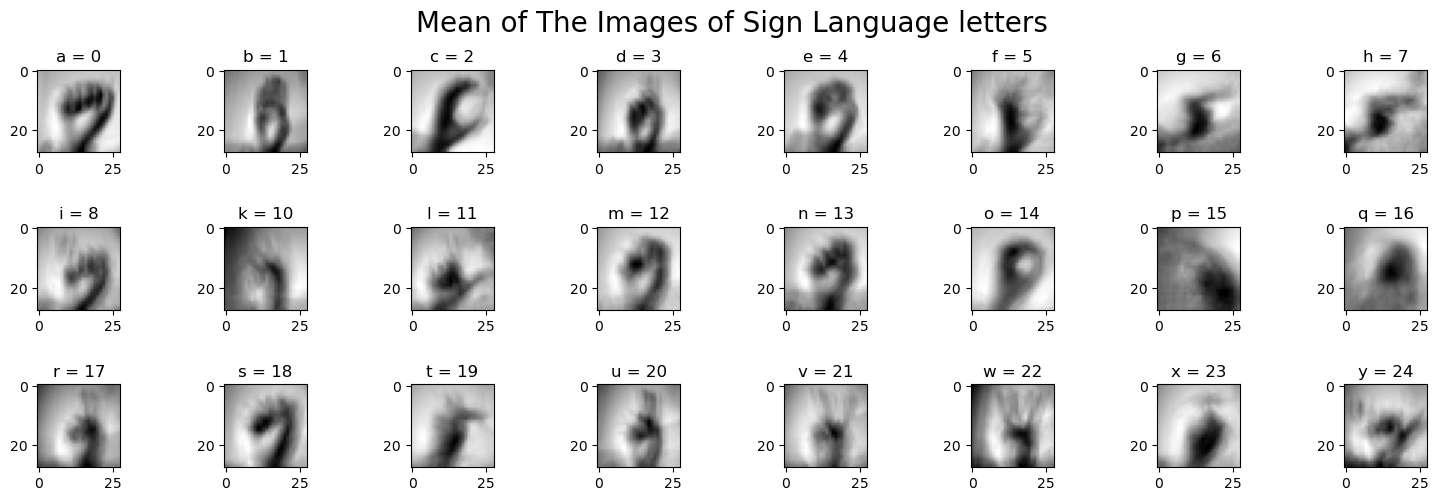

In [8]:
# create the figure and adjust the size
plt.figure(figsize=(18,3));
plt.gcf().suptitle("Mean of The Images of Sign Language letters", fontsize=20, y=3.2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=3, 
                    wspace=0.4, 
                    hspace=0.9)

# for each unique letter in the data
for index, val in enumerate(np.unique(YTrainData)):
    # find the position where the mean is of a certain letter    
    u_img = u_ml[index].reshape(28, 28)
    
    plt.subplot(6,8,index+1);         
    plt.imshow(u_img, cmap='gray') 
    
     # add the label to the picture
    plt.title(target_names[Labels[index]] + " = " + str(val))          
plt.show()

The images appear blurry, but it's still possible to identify the hand gesture in order to translate the sign langauge letter. <br>
For each label we take all the examples, and calculate the average of each pixel. <br>
As a result, we lose the details in each example, but we gain the average representation of the letter. <br>
We can see that for letters that less spread in the area, we get a much clearer representation, for e.g. letter 'a' and 'o', in comparasion to the letters 'q' and 'x'. <br>
The spread of the sign letter causes the averaging to be worse, that translates into the different ways one could gesture the letter, which causes the mean to be unclear.

<h3>4:QDA Performance for the Train Dataset</h3>

In [9]:
def eval_perform(classification, Y):
    """    
    Input: classification vector - Represents the predicted classification
           Y vector - Represents the true classification of the data
    Output: accuracy vector - Represents the accuracy as the correct classifications in ratio to all classifications
            precision vector - Represents the precision which is the positive predictive value, true positives in ratio to the selected elements
            recall vector - Represents the recall as the sensitivity, true positives in ratio to the relevant elements
            confMat matrix - Represents the confusion matrix, also known as the error matrix
            
            
    Description: Calculates the metrics of the classifier
    """
    # calculate the accuracy
    accuracy = (classification==Y).mean()
    
    # dimensions of the labels
    dim = len(np.unique(Y))
    
    # init confusion matrix       
    confMat = np.zeros([dim,dim])
    
    # init precision and recall vectors
    precision = np.zeros([dim])
    recall = np.zeros([dim])
    
    # for each truth and prediction   
    # each row of the matrix represents the instances in an actual class 
    for ytrue in np.unique(Y):
        # while each column represents the instances in a predicted class    
        for ypred in np.unique(Y):
            
            # according to ytrue and ypred, summerize all the examples that match it.
            # instances of the ytrue class in Y, that matches the classification of the ypred class
            # the match is calculated as a logical multiplication
            # save the summary in the confusion matrix in the correct cell            
            confMat[ytrue, ypred] = ((Y==ytrue)*(classification==ypred)).sum()           
    
    # for each truth and prediction
    for i in range(len(np.unique(Y))):
        # true positive
        tp = confMat[i,i]        
        
        # false positive
        fp = np.sum(confMat[:,i])-tp
        
        # false negative
        fn = np.sum(confMat[i,:])-tp
        
        # precision as the true positives in ratio to the selected elements
        precision[i] = tp/(tp+fp)
        
        # recall as the true positives in ratio to the relevant elements
        recall[i] = tp/(tp+fn)
        
    return [accuracy, precision, recall, confMat.astype(int)]

<b>Classify the Train Dataset using the QDA model</b>

In [10]:
# using the classification function to predict the train dataset
import time
t = time.time()
train_classification = classify(XTrain, pi_ml, u_ml, cov_ml)
elapsed = time.time() - t
print("Elapsed time for classifying: " + str(elapsed))

Elapsed time for classifying: 15.325199365615845


In [11]:
# using the evaluate performance function to evaluate the accuracy, precision, recall and confusion matrix for the train dataset
[train_accuracy, train_precision, train_recall, train_confMat] = eval_perform(train_classification, YTrain)

<h4><u>4a: Classifier Accuracy</u> $P_c(f,D)$</h4>

When evaluating the accuracy of a classifier, we calculate the correct classification in a ratio of all classifications. <br>
Classification accuracy tells us the percent of the total classification predictions that were correct. <br>
Usage of the accuracy metric in classifier performance evaluation is optimal, when our dataset is balanced. <br>
Accuracy gives an overal prespective on the classifier, however fails to distinguish between different types of errors. <br>
Accuracy fails to provide information about which classes it performs well on and which it performs poorly on. <br>
Accuracy also fails to provide insight into the confidence that the model has about its predictions. <br>
Additional aspect when evaluating the performance is, high accuracy can lead to overfitting.<br>

In [12]:
print("Accuracy on train dataset = " + str(train_accuracy*100) + "%")

Accuracy on train dataset = 100.0%


The accuracy on the train dataset when using our QDA classifier is 100%, which means all of the examples have been predicted correctly. <br>
Therefore using accuracy for evaulating the train dataset is good, however we need to take in consideration that it could perform poorly on unseen examples, due to possibility of overfitting. <br>

In [13]:
# calculate for each label, the number of examples it has in the dataset and the percentage of it
print("Train Dataset Distribution:\n")
for index, val in enumerate(np.unique(YTrain)):
    count = np.sum(YTrain==index)
    percent = round(count/len(YTrain)*100,2)
    
    print("Letter " + target_names[Labels[index]] + " = " + str(count) + ", " + str(percent) + "%")

Train Dataset Distribution:

Letter a = 1126, 4.1%
Letter b = 1010, 3.68%
Letter c = 1144, 4.17%
Letter d = 1196, 4.36%
Letter e = 957, 3.49%
Letter f = 1204, 4.39%
Letter g = 1090, 3.97%
Letter h = 1013, 3.69%
Letter i = 1162, 4.23%
Letter k = 1114, 4.06%
Letter l = 1241, 4.52%
Letter m = 1055, 3.84%
Letter n = 1151, 4.19%
Letter o = 1196, 4.36%
Letter p = 1088, 3.96%
Letter q = 1279, 4.66%
Letter r = 1294, 4.71%
Letter s = 1199, 4.37%
Letter t = 1186, 4.32%
Letter u = 1161, 4.23%
Letter v = 1082, 3.94%
Letter w = 1225, 4.46%
Letter x = 1164, 4.24%
Letter y = 1118, 4.07%


Our dataset is relatively balanced, as we can see each label has roughly an equal number of classes ~4% of all the dataset. <br>

<h4><u>4b: Classifier Confusion Matrix</u> $P_c(f,D)$</h4>

A confusion matrix is a table that summarizes the performance of a classification model by comparing its predicted labels to the true labels. It displays the different kinds of predictions: true positives (tp), true negatives (tn), false positives (fp), and false negatives (fn). <br>
In our dataset, we have 24 labels, therefore a confusion matrix of 24x24. <br>

In [14]:
import seaborn as sns

# colormap of the confusion matrix
train_cm = sns.light_palette("green", as_cmap=True)

# take the train cofusion matrix and convert it to dataframe
train_confMat_df = pd.DataFrame(train_confMat)

# rename the columns and indexes to match the data labels
train_confMat_df.columns = target_names[Labels]
train_confMat_df.index = target_names[Labels]

# display all the columns and indexes
pd.set_option('display.max_columns', None)

# add the style and title
train_confMat_df.style.set_caption("<h1 style='text-align: center'>Confusion Matrix on Train Dataset</h1>").background_gradient(cmap=train_cm)

,a,b,c,d,e,f,g,h,i,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y
a,1126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,1010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c,0,0,1144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,1196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f,0,0,0,0,0,1204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,0,1090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,0,1013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
i,0,0,0,0,0,0,0,0,1162,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
k,0,0,0,0,0,0,0,0,0,1114,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As we can see in the confusion matrix, all of the predictions were correct, which turned the confusion matrix into a diagonal matrix. <br>
For each label, we can see that the false negatives and false positives are zero.

<h4><u>4c: Classifier Precision and Recall</u> $P_c(f,D)$</h4>

Precision and Recall are both metrics to evaluate the performance of the classifier. <br>
Usually we want to see them together to get a more precise image on how the model is performing. <br>

Precision is the number of True Positive predictions, divided by the total number of examples that were <b><u>predicted</u></b> as positive. <br>
Precision tells us the proportion of all of the positive predictions that were actually positive. <br>

Recall is the number of True Positive predictions, divided by the total number of <b><u>actual</u></b> positive examples. <br>
Recall measures the ability of the model to correctly identity all of the actual positive examples. <br>

Precision makes sure that the model’s positive predictions are reliable, and recall ensures that the model correctly identifies all of the actual positive examples. <br>

In precision false negative is not checked, while in recall false positive is not checked. <br>
It may be valuable to prioritize one over the other in cases where the outcome of a false positive or false negative is costly. <br>

In [15]:
# take the train precision and recall and convert it to dataframe and rename the columns
train_precision_recall_df = pd.DataFrame({'Precision' : train_precision, 'Recall':train_recall})

# rename the indexes to match the data labels
train_precision_recall_df.index = target_names[Labels]
train_precision_recall_df

,Precision,Recall
a,1.0,1.0
b,1.0,1.0
c,1.0,1.0
d,1.0,1.0
e,1.0,1.0
f,1.0,1.0
g,1.0,1.0
h,1.0,1.0
i,1.0,1.0
k,1.0,1.0


As we can see in the precision and recall results, no examples were classified wrongly. <br>
Precision=1 means that for a given letter, there were no false alarms, or in other words the false positive is zero.<br>
Recall=1 means that for a given letter, there were no misses,  or in other words the false negative is zero.<br>
In our case, no letter has been classified as another letter.

<h3>5:QDA Performance for the Test Dataset</h3>

<h4><u>5-1a: Loading the test data and split into features and labels</u></h4>

In [16]:
# Load the train data
TestData = pd.read_pickle("TestData.pkl")

# split into features and labels
XTestData = TestData['X']
YTestData = TestData['Y']

<h4><u>5-1b: Images for every label in the test dataset</u></h4>

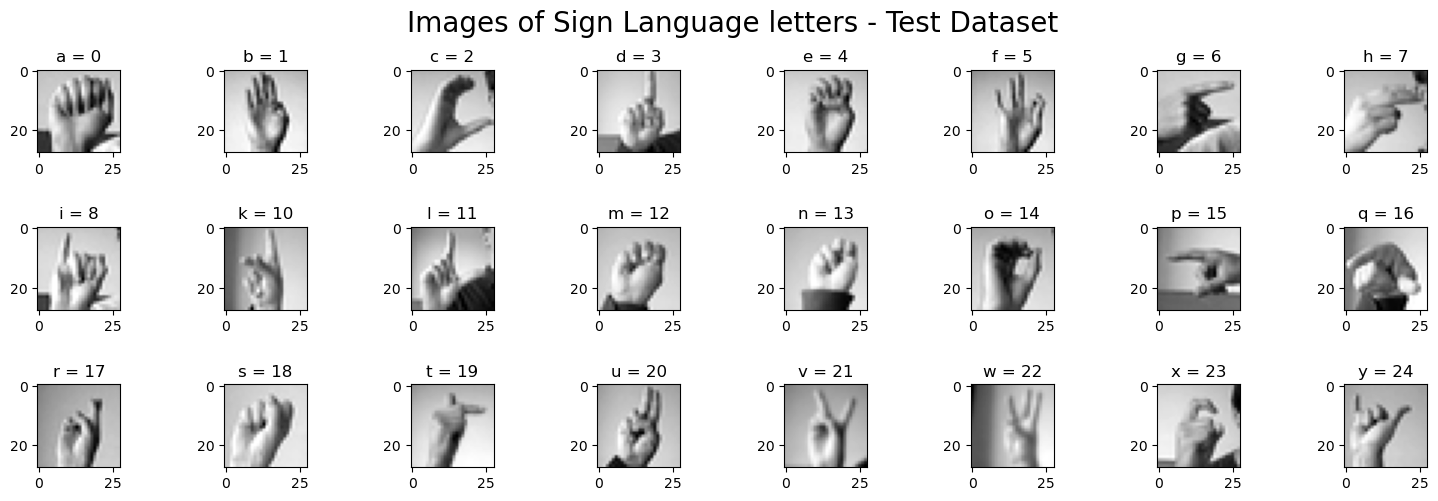

In [17]:
# create the figure and adjust the size
plt.figure(figsize=(18,3));
plt.gcf().suptitle("Images of Sign Language letters - Test Dataset", fontsize=20, y=3.2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=3, 
                    wspace=0.4, 
                    hspace=0.9)

# for each unique letter in the data
for index, val in enumerate(np.unique(YTestData)):
    # find the positions where the label is a certain letter
    pos = np.argwhere(YTestData==val)        
               
    plt.subplot(6,8,index+1);      
    
    # take the first occurence of the letter
    plt.imshow(XTestData[:,:,pos[0]], cmap='gray') 
    
    # add the label to the picture
    plt.title(target_names[val] + " = " + str(val))          
plt.show()

<h4><u>5-1c: Prepare the test data for the classifier</u></h4>

In [18]:
# using transpose to define the rows as the examples
# using reshape to convert from 3d to 2d matrix
# using astype to convert data type from int to float64
XTest = XTestData.transpose(2,0,1).reshape(XTestData.shape[2],-1).astype('float64')

# categorize the labels into labels in asscending order
# that way our QDA algorithm is independent on missing values in the data
[Labels, YTest] = np.unique(YTestData, return_inverse=True)

<b>Classify the Test Dataset using the QDA model</b>

In [19]:
# using the classification function to predict the test dataset
import time
t = time.time()
test_classification = classify(XTest, pi_ml, u_ml, cov_ml)
elapsed = time.time() - t
print("Elapsed time for classifying: " + str(elapsed))

Elapsed time for classifying: 7.344601392745972


In [20]:
# using the evaluate performance function to evaluate the accuracy, precision, recall and confusion matrix for the test dataset
[test_accuracy, test_precision, test_recall, test_confMat] = eval_perform(test_classification, YTest)

<h4><u>5-4a: Classifier Accuracy</u> $P_c(f,D)$</h4>

In [21]:
print("Accuracy on train dataset = " + str(train_accuracy*100) + "%")
print("Accuracy on test dataset = " + str(test_accuracy*100) + "%")

Accuracy on train dataset = 100.0%
Accuracy on test dataset = 92.43285630268575%


As we can see, the test accuracy is high. we can learn from that our classifier performs well on unseen examples. <br>
As expressed in 4-a, high accuracy on train dataset, specifically for a perfect accuracy of 100%, we can be in a situation of overfitting, however since the accuracy of the test dataset is relatively high, we can assume that an overfitting has not occured. <br>
One of the reasons that this classifier performs well, is because in the train dataset, the dataset was balanced.

In [22]:
# calculate for each label, the number of examples it has in the dataset and the percentage of it
print("Test Dataset Distribution:")
for index, val in enumerate(np.unique(YTest)):
    count = np.sum(YTest==index)
    percent = round(count/len(YTest)*100,2)
    
    print("Letter " + target_names[Labels[index]] + " = " + str(count) + ", " + str(percent) + "%")

Test Dataset Distribution:
Letter a = 331, 6.49%
Letter b = 291, 5.7%
Letter c = 293, 5.74%
Letter d = 231, 4.53%
Letter e = 234, 4.59%
Letter f = 245, 4.8%
Letter g = 264, 5.18%
Letter h = 208, 4.08%
Letter i = 235, 4.61%
Letter k = 245, 4.8%
Letter l = 193, 3.78%
Letter m = 198, 3.88%
Letter n = 227, 4.45%
Letter o = 175, 3.43%
Letter p = 115, 2.25%
Letter q = 164, 3.22%
Letter r = 140, 2.74%
Letter s = 228, 4.47%
Letter t = 162, 3.18%
Letter u = 175, 3.43%
Letter v = 149, 2.92%
Letter w = 186, 3.65%
Letter x = 178, 3.49%
Letter y = 234, 4.59%


However, in the test dataset, we see that there is an imbalance distribution, for e.g. the number of occurrences of the letter 'a' is about two times bigger than some other letters. <br>
This could result in not a full and clear view about the evaluation of the classifier performance.

<h4><u>5-4b: Classifier Confusion Matrix</u> $P_c(f,D)$</h4>

In [23]:
# colormap of the confusion matrix
test_cm = sns.light_palette("blue", as_cmap=True)

# take the test cofusion matrix and convert it to dataframe
test_confMat_df = pd.DataFrame(test_confMat)

# rename the columns and indexes to match the data labels
test_confMat_df.columns = target_names[Labels]
test_confMat_df.index = target_names[Labels]

# display all the columns and indexes
pd.set_option('display.max_columns', None)

# add the style and title
test_confMat_df.style.set_caption("<h1 style='text-align: center'>Confusion Matrix on Test Dataset</h1>").background_gradient(cmap=test_cm)

,a,b,c,d,e,f,g,h,i,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y
a,331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,270,0,4,0,0,0,0,0,3,0,0,0,0,0,5,3,0,0,0,0,6,0,0
c,0,0,289,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
d,0,0,0,226,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
e,0,0,0,0,191,0,0,0,0,0,0,0,9,0,0,11,0,23,0,0,0,0,0,0
f,0,0,0,0,0,245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,0,246,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,7,168,0,0,0,0,0,0,0,26,0,0,7,0,0,0,0,0
i,0,0,0,0,0,0,0,0,227,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0
k,0,0,0,0,0,0,0,0,0,228,0,0,0,0,0,4,13,0,0,0,0,0,0,0


As we can see in the confusion matrix, we get high values for the diagonal, which means the majority of the letters are classified correctly. <br>
The confusion matrix is not a diagonal matrix, in comparison to the confusion matrix on the train dataset, which was a diagonal matrix. <br>
We infer that the confusion matrix on the test dataset suggests the classifier performs well for some letters, but struggles with others. <br><br>
Lets examine the confusion matrix values on the test dataset:<br><br>
A lot of letters have been predicted as 'q', but weren't 'q' (false negative). but all of the letters that were 'q', have been predicted as 'q' (no false positive). <br>
If we look at the train dataset, we can see that the letter 'q' has the highest number of examples. This could be a reason for the confusion of other similar letters features with the letter 'q', because this could mean the classifier is biased towards the letter 'q', as $\pi_q$ is higher only because it has more examples. <br><br>
When we predicted the letter 'a' / 'f', it was always correctly the letter 'a' / 'f'. (fp - no false alarm) <br>
For all of the true letters 'a' / 'f', we always predicted the letter 'a' / 'f'. (fn - no miss) <br><br>

For similar letters in the sign language, we obsereved that there were a high number of misses. <br>
For example, 'v' letters classified as 'w', 'm' letters classified as 'n' ,'e' letters classified as 's'. <br>

<h4><u>5-4c: Classifier Precision and Recall</u> $P_c(f,D)$</h4>

In [24]:
# take the train and test precision and recall and convert it to dataframe and rename the columns
train_test_precision_recall_df = pd.DataFrame({'Train Precision' : train_precision, 'Train Recall':train_recall,
                                               'Test Precision' : test_precision, 'Test Recall':test_recall})

# rename the indexes to match the data labels
train_test_precision_recall_df.index = target_names[Labels]
train_test_precision_recall_df

,Train Precision,Train Recall,Test Precision,Test Recall
a,1.0,1.0,1.000000,1.000000
b,1.0,1.0,1.000000,0.927835
c,1.0,1.0,1.000000,0.986348
d,1.0,1.0,0.982609,0.978355
e,1.0,1.0,1.000000,0.816239
f,1.0,1.0,1.000000,1.000000
g,1.0,1.0,0.972332,0.931818
h,1.0,1.0,1.000000,0.807692
i,1.0,1.0,1.000000,0.965957
k,1.0,1.0,0.987013,0.930612


As we saw in the confusion matrix on the test dataset, when we observe the precision and recall, we can see that the letters 'a' and 'f' have a perfect score, 1.0 for both the precision and recall. <br>
Additionally, we can see that the letter 'q' has the lowest precision of 0.46, but a perfect recall of 1.0. <br>
Because the precision is focused on false positives, we can see that the classifier indeed struggles with false positives of the letter 'q'.<br>
And because the recall is focused on false negatives, we can see that the classifier indeed handles perfectly with false negatives of the letter 'q'. <br><br>
Although, in the train dataset we get a perfect recall and precision for all the letters, it doesn't mean that the classifier is optimal. The result of the precision and recall on the test dataset could help us in optimizing the classifier, by informing us which letters in the train dataset could be improved. <br><br>

Improving the classifier overall, will distance ourselfs from the overfitting problem and towards a more accurate classifier. <br>

<h3>6:Message Decoding</h3>

<h4><u>Loading the message data and extract features</u></h4>

In [25]:
# Load the message data
MessageData = pd.read_pickle("MessageData.pkl")

# extract features
XMessageData = MessageData['X']

<h4><u>Prepare the message data for the classifier</u></h4>

In [26]:
# using transpose to define the rows as the examples
# using reshape to convert from 3d to 2d matrix
# using astype to convert data type from int to float64
XMessage = XMessageData.transpose(2,0,1).reshape(XMessageData.shape[2],-1).astype('float64')

<h4><u>Find the spaces indexes</u></h4>

In [27]:
spaces_indexes = []
for index, sample in enumerate(XMessage):      
    if np.sum(sample)==0:
        spaces_indexes.append(index)

<h4><u>Decoding the message</u></h4>

In [28]:
# classify the characters in the message
message_classification = classify(XMessage, pi_ml, u_ml, cov_ml)

# convert into labels
decoded_message = target_names[Labels[message_classification]]

# put spaces according to the spaces indexes
decoded_message[spaces_indexes] = " "

<h4><u>Printing the message</u></h4>

In [29]:
print("The Decoded Message is:")
print(''.join(decoded_message))

The Decoded Message is:
a great way to learn how a machine learning algorithm works is by implementing it from scratch
